In [1]:
# 'Cell 1: Imports and Configuration'
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import sys
import os
import argparse
import backend.processing_logic as processing_logic

# --- Configuration ---
# 将配置从web_server.py复制到这里，以便独立测试
YOLO_MODEL_PATH = 'backend/resource/yolov8n.pt'
OLLAMA_API_URL = "http://localhost:11434/api/generate"
DEEPSEEK_MODEL_NAME = "deepseek-r1:8b" 
TEST_IMAGE_PATH = 'backend/resource/bus.jpg'  # 默认图片路径

# 解析命令行参数（可选，允许通过命令行指定模式）
parser = argparse.ArgumentParser(description='Image processing mode selection')
parser.add_argument('--mode', choices=['image', 'camera'], default='camera',
                    help='Choose input mode: "image" for local file, "camera" for webcam')
args = parser.parse_args(args=[])  # 在Jupyter中设置空参数，实际运行可通过命令行传递

print("Configuration set successfully.")
print(f"YOLO Model Path: {YOLO_MODEL_PATH}")
print(f"Ollama API URL: {OLLAMA_API_URL}")
print(f"DeepSeek Model: {DEEPSEEK_MODEL_NAME}")
print(f'Selected mode: {args.mode}')

Configuration set successfully.
YOLO Model Path: backend/resource/yolov8n.pt
Ollama API URL: http://localhost:11434/api/generate
DeepSeek Model: deepseek-r1:8b
Selected mode: camera


In [2]:
# 'Cell 2: Load YOLO Model'
print("Loading YOLO model...")
try:
    yolo_model = YOLO(YOLO_MODEL_PATH)
    print(f"YOLO model '{YOLO_MODEL_PATH}' loaded successfully.")
except Exception as e:
    print(f"Error loading YOLO model: {e}")
    yolo_model = None

Loading YOLO model...
YOLO model 'backend/resource/yolov8n.pt' loaded successfully.


Image captured from webcam successfully.


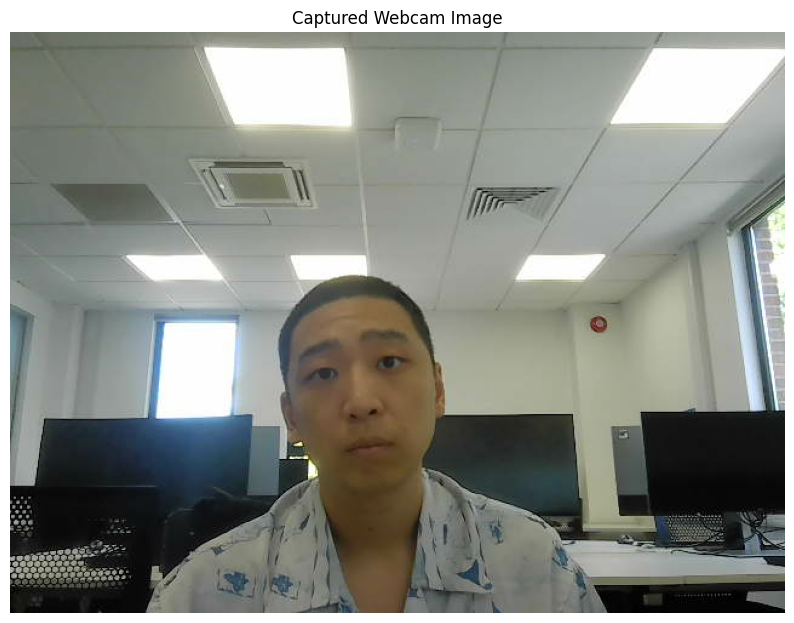

In [3]:
# 'Cell 3: Load and Display Test Image'

# 交互式模式选择（若未通过命令行指定）
mode = args.mode
if not hasattr(args, 'mode') or args.mode is None:
    mode = input('Select mode (image/camera): ').strip().lower()
    if mode not in ['image', 'camera']:
        print('Invalid mode. Defaulting to "image".')
        mode = 'image'

if mode == 'image':
    # 加载本地图片
    if not os.path.exists(TEST_IMAGE_PATH):
        print(f'Error: Test image not found at \'{TEST_IMAGE_PATH}\'')
        print('Please place a test image in the project root directory.')
        image_bgr = None
    else:
        image_bgr = cv2.imread(TEST_IMAGE_PATH)
        print(f'Image \'{TEST_IMAGE_PATH}\' loaded successfully.')
else:
    # 使用摄像头拍照
    cap = cv2.VideoCapture(0)  # 打开默认摄像头
    if not cap.isOpened():
        print('Error: Could not open webcam.')
        image_bgr = None
    else:
        ret, image_bgr = cap.read()  # 捕获一帧
        if not ret:
            print('Error: Could not capture image from webcam.')
            image_bgr = None
        else:
            print('Image captured from webcam successfully.')
        cap.release()  # 释放摄像头

# 显示输入图像
if image_bgr is not None:
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.title('Input Image' if mode == 'image' else 'Captured Webcam Image')
    plt.axis('off')
    plt.show()
else:
    print('No image loaded.')

In [4]:
print('Starting the full image processing pipeline...')
print('This may take a moment as it involves both YOLO detection and an LLM query.')

# 检查模型和图片是否都已成功加载
if 'yolo_model' in locals() and yolo_model is not None and 'image_bgr' in locals() and image_bgr is not None:
    # 调用核心处理函数
    natural_language_description, annotated_image_bgr, json_detections = processing_logic.process_image_and_describe(
        image_bgr,
        yolo_model,
        DEEPSEEK_MODEL_NAME,
        OLLAMA_API_URL
    )
    print('Processing complete.')
else:
    print('Skipping processing due to errors in previous steps (model or image not loaded).')
    natural_language_description = 'Processing failed.'
    annotated_image_bgr = image_bgr  # 仅显示原图（若存在）
    json_detections = None

Starting the full image processing pipeline...
This may take a moment as it involves both YOLO detection and an LLM query.

0: 480x640 1 person, 4 tvs, 1 keyboard, 114.6ms
Speed: 6.8ms preprocess, 114.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)
Processing complete.


Generated Description:
<think>
Okay, let's look at this JSON data first. The user wants me to describe an image based on detected objects with their attributes.

Hmm, I see several "person" and multiple "tv" detections with high confidence scores around 0.6-0.89. All the TVs have black colors too. Interesting pattern there! And there's also a keyboard detection at lower confidence but still notable.

The person is located in what seems to be an indoor setting, probably sitting somewhere because all objects are on the right side of the image according to their bounding boxes. The bbox coordinates [111, 200, 498, 479] show they're covering most of the visible area - definitely a central subject.

For the TVs: 
- There's one at [20,317] (left side)
- Another larger one at [343,315] in the middle
- And the largest one on the far right [521,312]

All positioned horizontally and close together. The keyboard is near the bottom of this JSON response but actually located high up at coordinates 

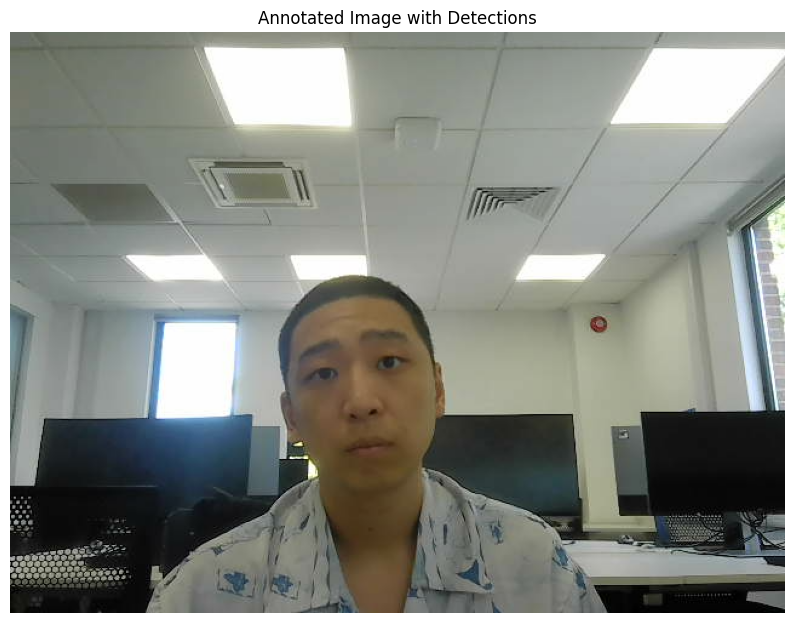

In [6]:
print('Generated Description:')
print(natural_language_description)

if annotated_image_bgr is not None:
    # 转换颜色通道从BGR到RGB以便matplotlib正确显示
    annotated_image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    # 显示标注后的图片
    plt.figure(figsize=(10, 8))
    plt.imshow(annotated_image_rgb)
    plt.title('Annotated Image with Detections')
    plt.axis('off')  # 关闭坐标轴
    plt.show()
else:
    print('No annotated image available.')

In [7]:
if json_detections is not None:
    print('You can now ask questions about the image. Type "quit" to exit.')
    while True:
        question = input('Enter your question: ').strip()
        if question.lower() == 'quit':
            print('Exiting question mode.')
            break
        answer = processing_logic.answer_question_about_image(
            json_detections,
            question,
            OLLAMA_API_URL,
            DEEPSEEK_MODEL_NAME
        )
        print('Answer:', answer)
else:
    print('Cannot ask questions: No detection data available.')

You can now ask questions about the image. Type "quit" to exit.
Answer: <think>
Okay, let's tackle this query step by step. The user asked "what you have seen" but didn't specify what exactly they want to know. 

First, I need to understand if there are any visual details we can infer from the detection data provided. Looking at the JSON structure, it contains image dimensions (480 height, 640 width) and object information with class names, colors, and bounding boxes.

The detected objects are all "tv" except for one "keyboard". All TVs are black based on their color property. Their positions show they're stacked vertically - the first TV's bottom is at y=479 (almost full height), second from top has x position around 343, etc. The keyboard appears to be positioned below some of these objects.

Without pixel-level data or actual image content, I can only describe what might be visible through qualitative observation. Since all TVs are black and stacked with similar y-coordinates sugges